# Описание проекта: Маркетинг  
  
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. 
Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.  

# Цель проекта  
  
Нам предстоит выполнить инженеринг признаков, обучить и оптимизировать модель бинарной классификации, которая предскажет вероятность совершения покупки пользователем в течение 90 дней.  

# Краткий план действий  
- Импортировать необходимые библиотеки, загрузить и изучить данные.
- Разработать новые полезные признаки.
- Создать модель для классификации пользователей.
- Улучшить модель и максимизировать метрику roc_auc.
- Выполнить тестирование.

# Описание данных  

1. **apparel-purchases:**  
● **client_id** - идентификатор клиента  
● **quantity** - количество единиц товара  
● **price** - цена товара  
● **category_ids** - идентификаторы категорий  
● **date** - дата покупки  
● **message_id** - идентификатор сообщения из рассылки  

2. **apparel-messages:**  
● **bulk_campaign_id** - идентификатор рассылки  
● **client_id** - идентификатор клиента  
● **message_id** - идентификатор сообщения  
● **event** - действие с сообщением (отправлено, открыто, покупка…)  
● **channel** - канал рассылки  
● **date дата** - действия  
● **created_at** - дата-время полностью  
  
3. **apparel-target_binary(совершит ли клиент покупку в течение следующих 90 дней):**  
● **client_id** - идентификатор клиента  
● **target** - целевой признак 

## 1. Импортируем данные

In [1]:
!pip install phik -q
!pip install shap -q
!pip install optuna -q
!pip install optuna-integration[sklearn] -q


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import phik
from phik import phik_matrix
import shap

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from optuna.integration import OptunaSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
import lightgbm
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

## 2. Загрузим и изучим данные

In [4]:
df_purchases = pd.read_csv(r'C:\Users\frakt\Downloads\workshop_2\DATA\apparel-purchases.csv')
df_messages = pd.read_csv(r'C:\Users\frakt\Downloads\workshop_2\DATA\apparel-messages.csv')
df_target = pd.read_csv(r'C:\Users\frakt\Downloads\workshop_2\DATA\apparel-target_binary.csv')

In [5]:
display(df_purchases.info())
df_purchases.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


None

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


In [6]:
display(df_messages.info())
df_messages.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


None

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


In [7]:
display(df_target.info())
df_target.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
5,1515915625468061514,0
6,1515915625468061877,0
7,1515915625468061975,0
8,1515915625468061994,0
9,1515915625468062158,0


Изменим тип данных у столбцов с датой на **datetime64** и проверим данные на наличие пропусков.

In [8]:
df_purchases['date'] = pd.to_datetime(df_purchases['date'], format='%Y-%m-%d')
df_messages['date'] = pd.to_datetime(df_messages['date'], format='%Y-%m-%d')
df_messages['created_at'] = pd.to_datetime(df_messages['created_at'], format='%Y-%m-%d %H:%M:%S')

In [9]:
df_purchases.info()
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date            

### 2.1 Проверим наличие пропусков в данных

In [10]:
df_purchases.isna().sum()

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

In [11]:
df_messages.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

In [12]:
df_target.isna().sum()

client_id    0
target       0
dtype: int64

Пропущенные значения в данных остутствуют.

### 2.2 Выведем уникальные значения для кажодго категориального столбца

In [13]:
print('Уникальные значения в столбце event')
display(df_messages['event'].unique())
print('Уникальные значения в столбце channel')
df_messages['channel'].unique()

Уникальные значения в столбце event


array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

Уникальные значения в столбце channel


array(['email', 'mobile_push'], dtype=object)

### 2.3 Проверим данные на наличие дубликатов

In [14]:
print('Количество дубликатов в df_messages:', df_messages.duplicated().sum())
print('Количество дубликатов в df_purchases:', df_purchases.duplicated().sum())
print('Количество дубликатов в df_target:', df_target.duplicated().sum())

Количество дубликатов в df_messages: 48610
Количество дубликатов в df_purchases: 73020
Количество дубликатов в df_target: 0


В df_messages и df_purchases были найдены дубликаты. Из таблицы df_messages удалим дубликаты, а в df_purchases пока не будем их убирать, поскольку пропадет большой процент данных. Так же в обеих таблицах оставим только тех клиентов, которые есть в df_target.

In [15]:
df_messages = df_messages[df_messages['client_id'].isin(df_target['client_id'])]
df_purchases = df_purchases[df_purchases['client_id'].isin(df_target['client_id'])]

df_messages = df_messages.drop_duplicates().reset_index(drop=True)

In [16]:
display(df_messages.info())
df_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10913197 entries, 0 to 10913196
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 582.8+ MB


None

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [17]:
display(df_purchases.info())
df_purchases.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


None

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


**Вывод:**  

В ходе предобработки данных мы проверили их на наличие пропусков и дубликатов и избавились от них, только в таблице df_purchases не трогали дубликаты, поскольку пропадет большое количество записей. Так же изменили типы данных с датой и проверили уникальные значение в категориальных признаках.

## 3. Проведем исследовательский анализ данных

In [18]:
def df_visualization(df):
    for column in df.columns:
        column_type = df[column].dtype
        
        if column_type in ['int64', 'float64', 'datetime64[ns]'] and column !='client_id':
            fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 4))
            axes = axes.ravel()
            sns.histplot(data = df[column], kde=True, bins = 20, ax=axes[0])
            axes[0].set_title(column)
            mean = df[column].mean()
            axes[0].axvline(mean, color = 'red', linestyle = '-', label = f'Mean: {mean:.2f}' )
            median = df[column].median()
            axes[0].axvline(median, color = 'yellow', linestyle = '--', label = f'Median: {median:.2f}')
            axes[0].legend()
            axes[0].legend(loc = 'upper right')

            sns.boxplot(x=df[column], ax=axes[1])
            axes[1].set_title(f'{column}')
            axes[1].set_xlabel(column)
            plt.show()

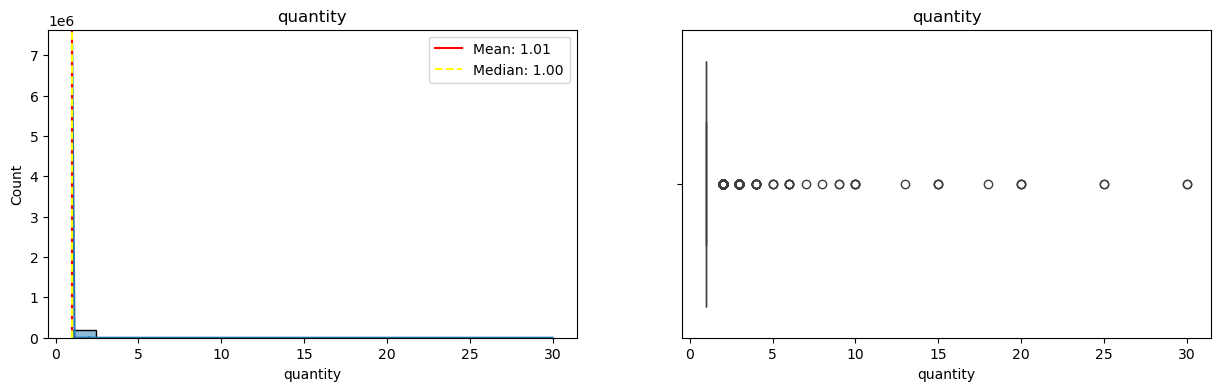

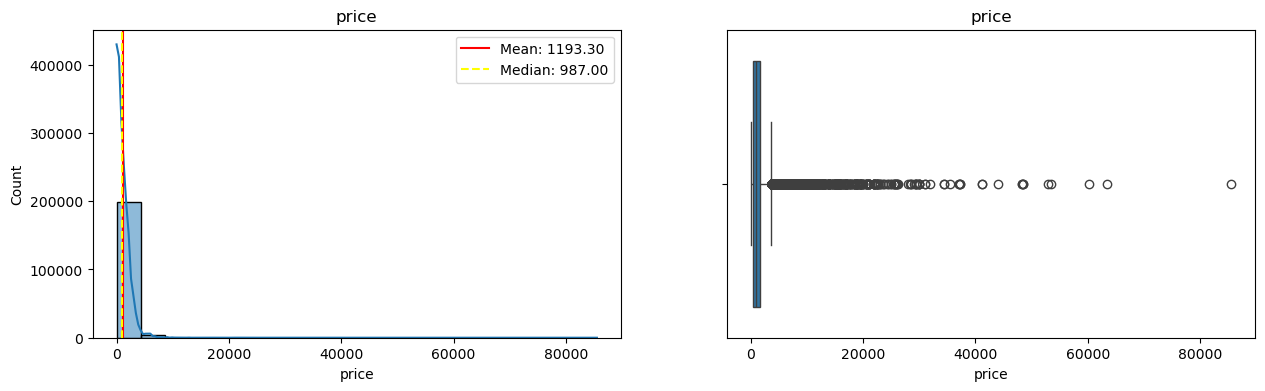

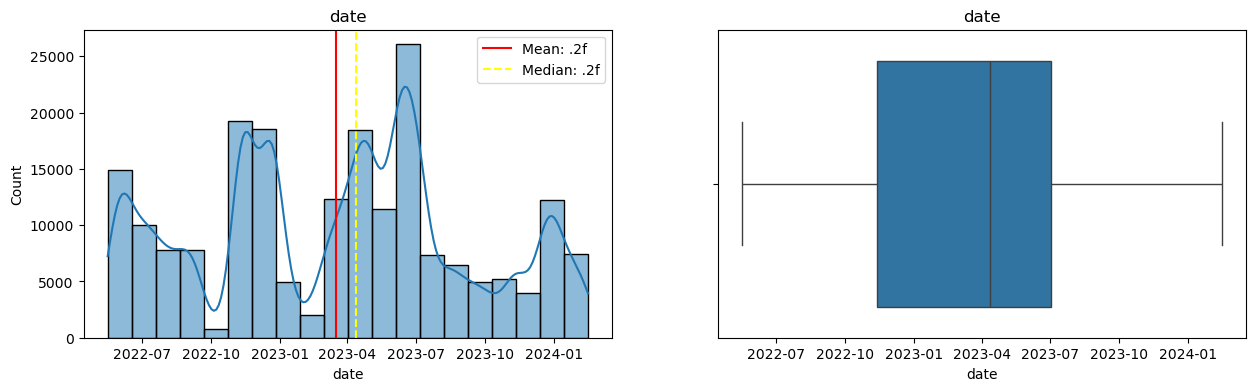

In [19]:
df_visualization(df_purchases)

In [20]:
print('Распределение значений столбца quantity')
display(df_purchases['quantity'].describe())
print()
print('Распределение значений столбца price')
display(df_purchases['price'].describe())
print()
df_purchases['year'] = df_purchases['date'].dt.year
print('Распределение значений столбца year')
df_purchases['year'].describe()

Распределение значений столбца quantity


count    202208.000000
mean          1.006483
std           0.184384
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: quantity, dtype: float64


Распределение значений столбца price


count    202208.000000
mean       1193.301516
std        1342.252664
min           1.000000
25%         352.000000
50%         987.000000
75%        1699.000000
max       85499.000000
Name: price, dtype: float64


Распределение значений столбца year


count    202208.000000
mean       2022.650291
std           0.579045
min        2022.000000
25%        2022.000000
50%        2023.000000
75%        2023.000000
max        2024.000000
Name: year, dtype: float64

**Вывод:**  
  
В нашем распоряжении данные за 2 года, с 2022 по 2024.  
Основная часть данных находится в диапазоне с ценами от 350 до 1700. Так же есть и выбивающиеся значения по типу 85499, данные значения можно объяснить наличием дорогостоящих товаров в интернет магазине. По распределению значений столбца quantity видно, что клиенты заказывали от 1 до 30 товаров за раз.

Далее посчитаем, сколько каждый пользователь совершил действий.

In [21]:
actions_count = pd.pivot_table(data=df_messages, index='client_id', columns='event', aggfunc='size', fill_value=0).reset_index()
actions_count.head(10)

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
0,1515915625468060902,10,0,0,0,0,35,5,126,0,0,1
1,1515915625468061003,5,0,0,0,0,5,1,154,0,0,0
2,1515915625468061099,8,0,0,2,0,51,0,215,0,0,0
3,1515915625468061100,1,0,0,1,0,157,1,267,1,0,0
4,1515915625468061170,16,0,0,0,0,31,3,243,0,0,0
5,1515915625468061514,12,0,0,0,0,17,1,150,0,0,0
6,1515915625468061877,5,0,0,0,0,50,1,173,0,0,0
7,1515915625468061975,7,0,0,0,1,17,1,154,0,0,0
8,1515915625468061994,9,0,0,0,0,21,2,346,0,0,0
9,1515915625468062158,29,0,0,0,0,28,2,113,0,0,0


Далее разделим значения стобца **category_ids**, сделав из них новые отдельные признаки.

In [22]:
df_purchases['category_ids'] = df_purchases['category_ids'].str.replace(r"[\[\]' ]", "", regex=True).str.split(',')
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id,year
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,2022
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,2022
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,2022
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,2022
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,2022


In [23]:
category_split = df_purchases['category_ids'].apply(pd.Series)
category_split.columns = [f'category_{i+1}' for i in category_split.columns]
df_purchases = pd.concat([df_purchases, category_split], axis=1)

In [24]:
df_purchases.head(10)

,client_id,quantity,price,category_ids,date,message_id,year,category_1,category_2,category_3,category_4,category_5
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,2022,4,28,57,431,NaN
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,2022,4,28,57,431,NaN
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,2022,4,28,57,431,NaN
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,2022,4,28,244,432,NaN
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,2022,4,28,49,413,NaN
5,1515915625471640575,1,3499.0,"[2, 18, 258, 441]",2022-05-16,1515915625471640575-4301-627b661b67ac3,2022,2,18,258,441,NaN
6,1515915625490211585,1,1699.0,"[2, 18, 341, 1311]",2022-05-16,1515915625490211585-4301-627b661843283,2022,2,18,341,1311,NaN
7,1515915625490739153,1,1999.0,"[2, 18, 123, 451]",2022-05-16,1515915625490739153-4172-626b943cc789b,2022,2,18,123,451,NaN
8,1515915625491478747,1,999.0,"[5562, 5631, 5549, 667]",2022-05-16,1515915625491478747-4273-6274ceb769d59,2022,5562,5631,5549,667,NaN
9,1515915625491651493,1,699.0,"[5562, 5630, 5649, 678]",2022-05-16,1515915625491651493-4437-6282242f2a9e2,2022,5562,5630,5649,678,NaN


Проверим количество пропущенных значений в новых столбцах.

In [25]:
df_purchases.isna().sum()

client_id            0
quantity             0
price                0
category_ids         0
date                 0
message_id           0
year                 0
category_1           0
category_2        6843
category_3        6843
category_4        8199
category_5      201690
dtype: int64

Можно заметить, что в 5-й категории довольно много пропущенных значений. Из-за наличия такого большого количества пропусков данную категорию можно считать неинформативной, поэтому уберем эту категорию из таблицы, а в остальных категориях удалим записи с пропущенными значениями.

In [26]:
df_category = df_purchases[['client_id', 'category_1', 'category_2', 'category_3', 'category_4']]
df_category = df_category.dropna()
df_category.info()
df_category.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 194009 entries, 0 to 202207
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   client_id   194009 non-null  int64 
 1   category_1  194009 non-null  object
 2   category_2  194009 non-null  object
 3   category_3  194009 non-null  object
 4   category_4  194009 non-null  object
dtypes: int64(1), object(4)
memory usage: 8.9+ MB


,client_id,category_1,category_2,category_3,category_4
0,1515915625468169594,4,28,57,431
1,1515915625468169594,4,28,57,431
2,1515915625471138230,4,28,57,431
3,1515915625471138230,4,28,244,432
4,1515915625471138230,4,28,49,413
5,1515915625471640575,2,18,258,441
6,1515915625490211585,2,18,341,1311
7,1515915625490739153,2,18,123,451
8,1515915625491478747,5562,5631,5549,667
9,1515915625491651493,5562,5630,5649,678


Изменим тип данных у новых признаков.

In [27]:
df_category[['category_1', 'category_2', 'category_3', 'category_4']] = df_category[['category_1', 'category_2', 
                                                                                               'category_3', 'category_4']].astype(int)
df_category.info()


<class 'pandas.core.frame.DataFrame'>
Index: 194009 entries, 0 to 202207
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   client_id   194009 non-null  int64
 1   category_1  194009 non-null  int32
 2   category_2  194009 non-null  int32
 3   category_3  194009 non-null  int32
 4   category_4  194009 non-null  int32
dtypes: int32(4), int64(1)
memory usage: 5.9 MB


Теперь посчитаем, сколько действий совершил каждый пользователь  по каналам рассылки.

In [28]:
channels_actions = pd.pivot_table(data=df_messages, index='client_id', columns='channel', aggfunc='size', fill_value=0).reset_index()
channels_actions.head(10)

channel,client_id,email,mobile_push
0,1515915625468060902,177,0
1,1515915625468061003,165,0
2,1515915625468061099,182,94
3,1515915625468061100,0,428
4,1515915625468061170,202,91
5,1515915625468061514,180,0
6,1515915625468061877,67,162
7,1515915625468061975,180,0
8,1515915625468061994,96,282
9,1515915625468062158,172,0


Так же посчитаем число и сумму всех покупок для каждого клиента.

In [29]:
all_purchases = df_purchases.groupby('client_id')['client_id'].count().reset_index(name='all_purchases')
sum_total = df_purchases.groupby('client_id')['price'].sum().reset_index(name='sum_total')
display(all_purchases.head())
sum_total.head()

,client_id,all_purchases
0,1515915625468060902,7
1,1515915625468061003,7
2,1515915625468061099,1
3,1515915625468061100,2
4,1515915625468061170,19


,client_id,sum_total
0,1515915625468060902,6993.0
1,1515915625468061003,16235.0
2,1515915625468061099,299.0
3,1515915625468061100,2098.0
4,1515915625468061170,33601.0


Мы создали новые признаки, теперь объеденим их в одну таблицу.

In [30]:
df_category

,client_id,category_1,category_2,category_3,category_4
0,1515915625468169594,4,28,57,431
1,1515915625468169594,4,28,57,431
2,1515915625471138230,4,28,57,431
3,1515915625471138230,4,28,244,432
4,1515915625471138230,4,28,49,413
...,...,...,...,...,...
202203,1515915626010261344,2,18,212,726
202204,1515915626010439406,4,27,233,462
202205,1515915626010439406,4,27,233,462
202206,1515915626010443527,2,18,274,446


In [31]:
final_df = all_purchases.merge(df_category, on='client_id').merge(actions_count, on='client_id')
final_df = final_df.merge(channels_actions, on='client_id').merge(sum_total, on='client_id')
final_df = final_df.merge(df_target, on='client_id')
final_df.head(10)

,client_id,all_purchases,category_1,category_2,category_3,category_4,click,close,complain,hard_bounce,...,open,purchase,send,soft_bounce,subscribe,unsubscribe,email,mobile_push,sum_total,target
0,1515915625468060902,7,4,27,176,458,10,0,0,0,...,35,5,126,0,0,1,177,0,6993.0,0
1,1515915625468060902,7,4,28,260,420,10,0,0,0,...,35,5,126,0,0,1,177,0,6993.0,0
2,1515915625468060902,7,4,27,1828,1599,10,0,0,0,...,35,5,126,0,0,1,177,0,6993.0,0
3,1515915625468060902,7,4,28,260,420,10,0,0,0,...,35,5,126,0,0,1,177,0,6993.0,0
4,1515915625468060902,7,4,27,176,458,10,0,0,0,...,35,5,126,0,0,1,177,0,6993.0,0
5,1515915625468060902,7,4,28,290,422,10,0,0,0,...,35,5,126,0,0,1,177,0,6993.0,0
6,1515915625468060902,7,4,28,244,432,10,0,0,0,...,35,5,126,0,0,1,177,0,6993.0,0
7,1515915625468061003,7,4,28,249,615,5,0,0,0,...,5,1,154,0,0,0,165,0,16235.0,1
8,1515915625468061003,7,4,28,249,615,5,0,0,0,...,5,1,154,0,0,0,165,0,16235.0,1
9,1515915625468061003,7,4,28,249,615,5,0,0,0,...,5,1,154,0,0,0,165,0,16235.0,1


В итоне у нас имеется таблица с новыми признаками, которые могут помочь модели обучиться и с хорошей точностью делать предсказания. Осталось лишь проверить данную таблицу на наличие дубликатов и убрать столбец **client_id**, поскольку при обучении модели он не понадобится.

In [32]:
final_df = final_df.drop(['client_id'], axis=1)

In [33]:
display(final_df.info())
print('Количество дубликатов в итоговой таблице:', final_df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159946 entries, 0 to 159945
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   all_purchases  159946 non-null  int64  
 1   category_1     159946 non-null  int32  
 2   category_2     159946 non-null  int32  
 3   category_3     159946 non-null  int32  
 4   category_4     159946 non-null  int32  
 5   click          159946 non-null  int64  
 6   close          159946 non-null  int64  
 7   complain       159946 non-null  int64  
 8   hard_bounce    159946 non-null  int64  
 9   hbq_spam       159946 non-null  int64  
 10  open           159946 non-null  int64  
 11  purchase       159946 non-null  int64  
 12  send           159946 non-null  int64  
 13  soft_bounce    159946 non-null  int64  
 14  subscribe      159946 non-null  int64  
 15  unsubscribe    159946 non-null  int64  
 16  email          159946 non-null  int64  
 17  mobile_push    159946 non-nul

None

Количество дубликатов в итоговой таблице: 83448


Удалим данные дубликаты.

In [34]:
final_df = final_df.drop_duplicates()
print('Количество дубликатов в итоговой таблице:', final_df.duplicated().sum())

Количество дубликатов в итоговой таблице: 0


In [35]:
final_df.isna().sum()

all_purchases    0
category_1       0
category_2       0
category_3       0
category_4       0
click            0
close            0
complain         0
hard_bounce      0
hbq_spam         0
open             0
purchase         0
send             0
soft_bounce      0
subscribe        0
unsubscribe      0
email            0
mobile_push      0
sum_total        0
target           0
dtype: int64

**Вывод:**  
  
По итогу проведенной работы мы проанализировали имеющиеся данные, провели предобработку данных и создали новые признаки. Далее выведем матрицу корреляции и посмотрим на зависимости признаков.

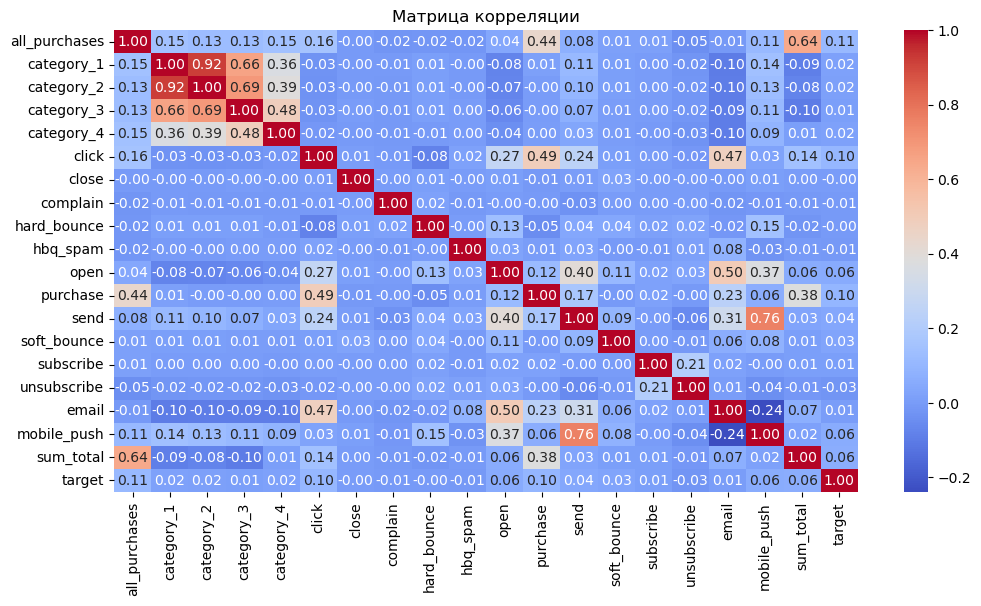

In [36]:
correlation_matrix = final_df.corr(method='spearman')
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляции')
plt.show()

**Вывод:**  

Можно сразу заметить, что категории между собой довольно сильно коррелируют, поэтому оставим только одну из них. А у целевого признака самая "высокая" корреляция только с признаками **all_purchases, click, purchase, open, mobile_push и sum_total**. Однако сами показатели корреляции не больше 0.2.

In [37]:
final_df = final_df.drop(['category_2', 'category_3', 'category_4'], axis=1).reset_index(drop=True)

## 4. Создадим модель для классификации пользователей

In [38]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76498 entries, 0 to 76497
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   all_purchases  76498 non-null  int64  
 1   category_1     76498 non-null  int32  
 2   click          76498 non-null  int64  
 3   close          76498 non-null  int64  
 4   complain       76498 non-null  int64  
 5   hard_bounce    76498 non-null  int64  
 6   hbq_spam       76498 non-null  int64  
 7   open           76498 non-null  int64  
 8   purchase       76498 non-null  int64  
 9   send           76498 non-null  int64  
 10  soft_bounce    76498 non-null  int64  
 11  subscribe      76498 non-null  int64  
 12  unsubscribe    76498 non-null  int64  
 13  email          76498 non-null  int64  
 14  mobile_push    76498 non-null  int64  
 15  sum_total      76498 non-null  float64
 16  target         76498 non-null  int64  
dtypes: float64(1), int32(1), int64(15)
memory usage: 9

In [39]:
X = final_df.drop(['target'], axis=1)
y = final_df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=y
)

In [40]:
display(X_train.shape)
X_test.shape

(61198, 16)

(15300, 16)

In [41]:
num_cols = X.select_dtypes(include='number').columns.tolist()
ohe_cols = X.select_dtypes(include='object').columns.tolist()

In [42]:
data_preprocessor = ColumnTransformer(
    [
        ('num', MinMaxScaler(), num_cols)
    ], 
    remainder='passthrough'
) 

In [43]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [44]:
param_grid = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, silent=True)],
        'models__depth': range(2, 6),
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__iterations': [100, 150, 200],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, penalty='l1', class_weight='balanced', solver='liblinear')],
        'models__C': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__n_estimators': [50, 250, 500],
        'models__num_leaves': [31, 45, 70],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [45]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    n_iter=5,
    random_state=RANDOM_STATE
)

In [46]:
randomized_search.fit(X_train, y_train)

print('Параметры лучшей модели:', randomized_search.best_estimator_)
print('Метрика ROC-AUC на тренировочных данных:', randomized_search.best_score_)

[LightGBM] [Info] Number of positive: 1823, number of negative: 59375
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1632
[LightGBM] [Info] Number of data points in the train set: 61198, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Параметры лучшей модели: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['all_purchases',
                                                   'category_1', 'click',
                                                   'close', 'complain',
                                       

**Вывод:**  

В итоге лучшей моделью оказалась LGBMClassifier с параметрами n_estimators=250 и random_state=42. Показатель метрики ROC-AUC на тренировочных данных составил 0.89.

In [47]:
y_pred = randomized_search.predict(X_test)
print('Метрика ROC-AUC на тестовых данных:', roc_auc_score(y_test, y_pred))

Метрика ROC-AUC на тестовых данных: 0.9015125728630387


Показатель ROC-AUC лучшей модели на тестовых данных составил 0.90.

Проведем анализ важности признаков.

 99%|===================| 15217/15300 [00:37<00:00]        

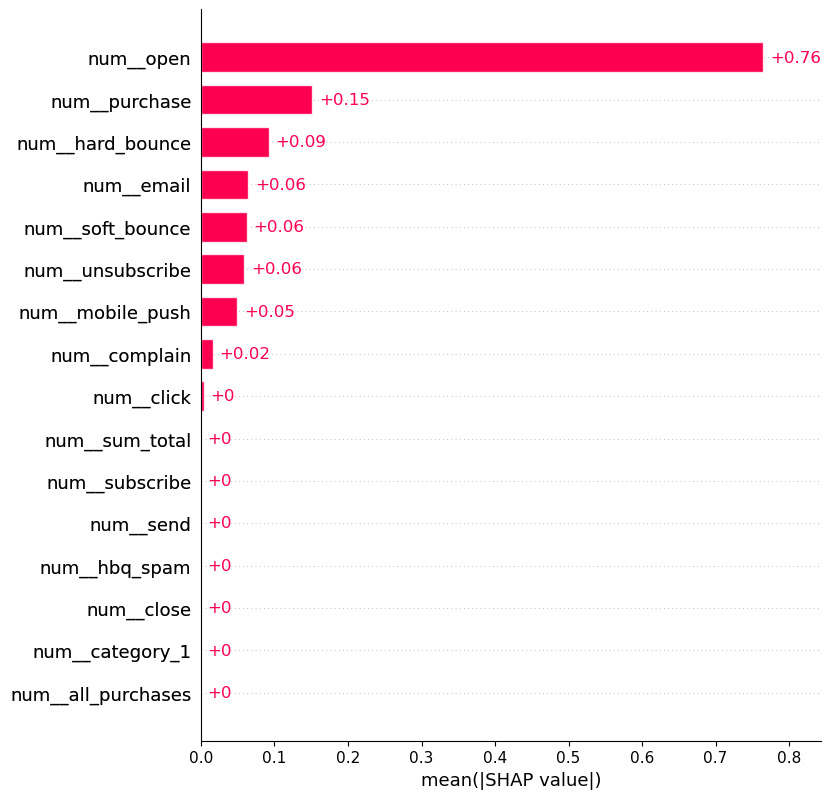

In [48]:
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)

explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], X_train_2)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)
shap_values = explainer(X_test_2)

shap.plots.bar(shap_values, max_display=50)

**Вывод:**  

Самыми важными признаками оказались **num_open, num_purchase и num_hard_bounce**. Показатели важности данных признаков составили 0.76, 0.15 и 0.09 соответственно.

## Итоговый вывод  

Нам было необходимо выполнить инженеринг признаков, обучить и оптимизировать модель бинарной классификации, которая предскажет вероятность совершения покупки пользователем в течение 90 дней.  

**В ходе данного исследования мы сделали следующее:**  
- Импортировали необходимые библиотеки и загрузили данные.  
- Провели предобработку и исследовательский анализ данных.  
- Разработали новые полезные признаки.  
- Создали модель для классификации пользователей и получили довольно хорошие показатели метрики ROC-AUC на тренировочных и тестовых данных.  

Самой лучшей моделью оказалась LGBMClassifier с параметрами n_estimators=250 и random_state=42 с показателем метрики ROC-AUC 0.89 на тренировочных данных и 0.90 на тестовых.

In [49]:
#!pip freeze > requirements.txt